In [1]:
#Импорты
import numpy as np
import os
import cv2
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
from bs4 import BeautifulSoup

In [2]:
#Загрузка изображений из папки
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
#Получение количества классов
def get_num_classes():
    persons = os.listdir('data')
    num_classes = len(persons)
    return num_classes

In [4]:
#Получение данных определённого размера для тренировки
def create_training_data(target_size):
    images = []
    labels = []
    persons = os.listdir('data')
    num_classes = len(persons)

    for person_index, person in enumerate(persons):
        folder_path = os.path.join('data', person)
        person_images = load_images_from_folder(folder_path)
        resized_images = [cv2.resize(img, target_size) for img in person_images]
        images.extend(resized_images)
        labels.extend([person_index] * len(resized_images))

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, num_classes

In [5]:
#Сама модель нейронки, на вход 150х150х3 картинка, на выходе определяет принодлежность к классу из num_classes
def create_model():
    num_classes=get_num_classes()
    
    input_shape = (150, 150, 3)
    
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = create_model()

In [6]:
#получение данных для тренировки, настройка данных и нейронки
target_size = (150, 150)
images, labels, num_classes = create_training_data(target_size)

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = np_utils.to_categorical(y_val, num_classes)
x_train = x_train / 255.0
x_val = x_val / 255.0

learning_rate = 0.001
batch_size = 32
epochs = 50

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)

datagen_train = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True)

datagen_train.fit(x_train)

In [7]:
#обучение
#checkpoint = ModelCheckpoint('model/retrained.h5', monitor='val_accuracy', verbose=1,
#                             save_best_only=True, mode='max')

#history = model.fit(
#    x_train,
#    y_train,
#    batch_size=batch_size,
#    epochs=epochs, 
#    shuffle=True,
#    validation_data=(x_val, y_val), 
#    callbacks=[checkpoint]
#)

In [8]:
#тест
test_images, test_labels, _ = create_training_data(target_size)
test_images = test_images / 255.0
test_labels = np_utils.to_categorical(test_labels, num_classes)
model.load_weights('model/retrained.h5')
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.7541497349739075
Test Accuracy: 0.8463541865348816


In [9]:
#методы для получения по картинке, и поиску в википедии
def get_person_info(person):
    search_query = f"{person}"
    url = f"https://www.google.com/search?q={search_query}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    search_results = soup.find_all('a')
    for result in search_results:
        link = result.get('href')
        if link.startswith("/url?q="):
            url = requests.utils.unquote(link[7:])
            url = url.split('&sa')[0] 
            if "wikipedia.org" in url:
                return url

    return None

def WHO(url):
    response = requests.get(url)
    image = np.array(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (150, 150))
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    predictions = model.predict(image)
    persons = os.listdir('data')
    predicted_person_index = np.argmax(predictions[0])
    predicted_person = persons[predicted_person_index]
    person_info = get_person_info(predicted_person)
    print(person_info)
    image = (image * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))
    plt.title(predicted_person)
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 45ms/step
https://ru.wikipedia.org/wiki/%D0%A2%D0%B0%D1%80%D0%B0%D0%BD%D1%82%D0%B8%D0%BD%D0%BE,_%D0%9A%D0%B2%D0%B5%D0%BD%D1%82%D0%B8%D0%BD


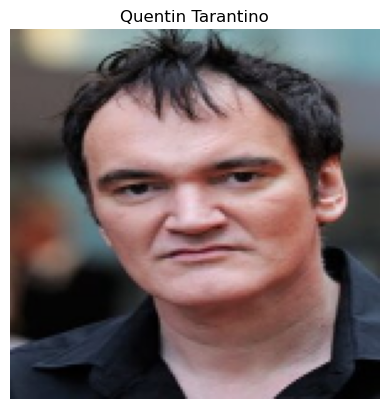

In [18]:
WHO('https://b1.filmpro.ru/c/7505.200x288.jpg')

1/1 [==============================] - 0s 37ms/step
https://ru.wikipedia.org/wiki/%D0%A2%D0%BE%D0%BB%D1%81%D1%82%D0%BE%D0%B9,_%D0%9B%D0%B5%D0%B2_%D0%9D%D0%B8%D0%BA%D0%BE%D0%BB%D0%B0%D0%B5%D0%B2%D0%B8%D1%87


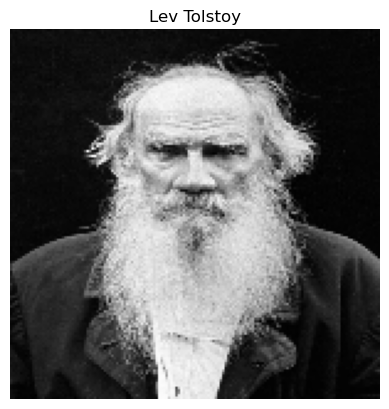

In [19]:
WHO('https://cdnn21.img.ria.ru/images/15107/76/151077691_0:0:0:0_600x0_80_0_1_7271a4fd0a9336b7aafaa47535c1d217.jpg')

In [ ]:
WHO('https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/%D0%95%D0%BA%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%BD%D0%B0_II._~1774%D0%B3._%D0%9F%D0%BE%D1%80%D1%82%D1%80%D0%B5%D1%82_%D0%9B%D0%B5%D0%B2%D0%B8%D1%86%D0%BA%D0%BE%D0%B3%D0%BE_Levitzky._Catherine_II_in_1794_e2_17.jpg/225px-%D0%95%D0%BA%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%BD%D0%B0_II._~1774%D0%B3._%D0%9F%D0%BE%D1%80%D1%82%D1%80%D0%B5%D1%82_%D0%9B%D0%B5%D0%B2%D0%B8%D1%86%D0%BA%D0%BE%D0%B3%D0%BE_Levitzky._Catherine_II_in_1794_e2_17.jpg')

1/1 [==============================] - 0s 41ms/step
